# **ResNet152**

In [ ]:
!pip install ipython-autotime
get_ipython().run_line_magic('load_ext', 'autotime')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 1.19 ms (started: 2022-12-07 22:05:38 +00:00)


# Data Aquisition: DiBAS Dataset

In [ ]:
!git clone https://github.com/YuandiWu/DiBAS-Images.git

fatal: destination path 'DiBAS-Images' already exists and is not an empty directory.
time: 118 ms (started: 2022-12-07 22:05:38 +00:00)


In [ ]:
!ls DiBAS-Images/train

Acinetobacter.baumanii	   Lactobacillus.plantarum
Actinomyces.israeli	   Lactobacillus.reuteri
Bacteroides.fragilis	   Lactobacillus.rhamnosus
Bifidobacterium.spp	   Lactobacillus.salivarius
Candida.albicans	   Listeria.monocytogenes
Clostridium.perfringens    Micrococcus.spp
Enterococcus.faecalis	   Neisseria.gonorrhoeae
Enterococcus.faecium	   Porfyromonas.gingivalis
Escherichia.coli	   Propionibacterium.acnes
Fusobacterium		   Proteus
Lactobacillus.casei	   Pseudomonas.aeruginosa
Lactobacillus.crispatus    Staphylococcus.aureus
Lactobacillus.delbrueckii  Staphylococcus.epidermidis
Lactobacillus.gasseri	   Staphylococcus.saprophiticus
Lactobacillus.jehnsenii    Streptococcus.agalactiae
Lactobacillus.johnsonii    Veionella
Lactobacillus.paracasei
time: 137 ms (started: 2022-12-07 22:05:38 +00:00)


# Library Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

time: 5.24 s (started: 2022-12-07 22:05:39 +00:00)


# Data Pre-processsing and augmentation

In [ ]:
original_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
original = datasets.ImageFolder("DiBAS-Images/train", transform=original_transform)

time: 13.8 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform1 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment1 = datasets.ImageFolder("DiBAS-Images/train", transform=transform1)

time: 15.6 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform2 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment2 = datasets.ImageFolder("DiBAS-Images/train", transform=transform2)

time: 7.17 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform3 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment3 = datasets.ImageFolder("DiBAS-Images/train", transform=transform3)

time: 12.3 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform4 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment4 = datasets.ImageFolder("DiBAS-Images/train", transform=transform4)

time: 11.4 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform5 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomAutocontrast(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment5 = datasets.ImageFolder("DiBAS-Images/train", transform=transform5)

time: 13.5 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform6 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomEqualize(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment6 = datasets.ImageFolder("DiBAS-Images/train", transform=transform6)

time: 21.3 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
transform7 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomInvert(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                ])
augment7 = datasets.ImageFolder("DiBAS-Images/train", transform=transform7)

time: 7.4 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
combined_dataset = torch.utils.data.ConcatDataset((original, augment1, augment2, augment3, augment4, augment5, augment6, augment7))

time: 1.01 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
def training_test_split(dataset, test_split=0.2):
    train_index, test_index = train_test_split(list(range(len(dataset))), test_size=test_split)
    training_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    return training_dataset, test_dataset

In [ ]:
def test_validation_split(dataset, test_split=0.5):
    validation_index, test_index = train_test_split(list(range(len(dataset))), test_size=test_split)
    validation_dataset = torch.utils.data.Subset(dataset, validation_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)
    return validation_dataset, test_dataset

time: 1.33 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
training_dataset, test_dataset = training_test_split(combined_dataset)
validation_dataset, test_dataset = test_validation_split(test_dataset)

time: 3.82 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

time: 9.55 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
def convert_to_image(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  return image

time: 1.58 ms (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
classes = ["Acinetobacter.baumanii", "Actinomyces.israeli","Bacteroides.fragilis", "Bifidobacterium.spp",
           "Candida.albicans", "Clostridium.perfringens", "Enterococcus.faecalis", "Enterococcus.faecium",
           "Escherichia.coli", "Fusobacterium", "Lactobacillus.casei", "Lactobacillus.crispatus", "Lactobacillus.delbrueckii",
           "Lactobacillus.gasseri", "Lactobacillus.jehnsenii", "Lactobacillus.johnsonii", "Lactobacillus.paracasei",
           "Lactobacillus.plantarum", "Lactobacillus.reuteri", "Lactobacillus.rhamnosus", "Lactobacillus.salivarius",
           "Listeria.monocytogenes", "Micrococcus.spp", "Neisseria.gonorrhoeae", "Porfyromonas.gingivalis",
           "Propionibacterium.acnes", "Proteus", "Pseudomonas.aeruginosa", "Staphylococcus.aureus", "Staphylococcus.epidermidis",
           "Staphylococcus.saprophiticus", "Streptococcus.agalactiae", "Veionella"]

time: 2.68 ms (started: 2022-12-07 22:05:44 +00:00)


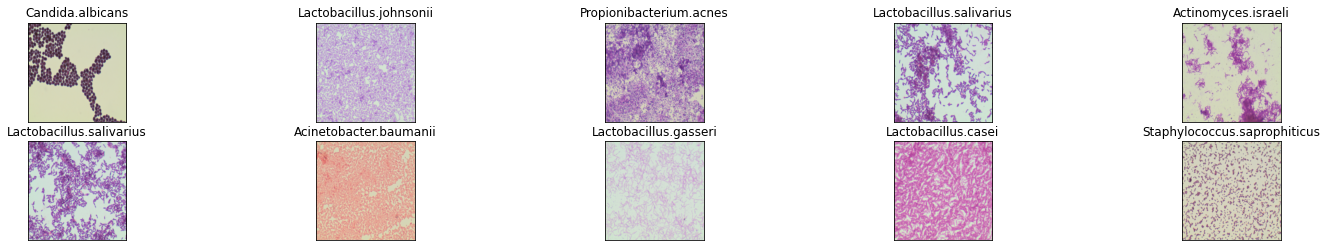

time: 2.23 s (started: 2022-12-07 22:05:44 +00:00)


In [ ]:
original_loader = torch.utils.data.DataLoader(dataset=original, batch_size=32, shuffle=True)
dataset_iterable = iter(original_loader)
images, labels = next(dataset_iterable)
fig = plt.figure(figsize=(25,4))
for i in np.arange(10): #showing sample of 16 images
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  plt.imshow(convert_to_image(images[i]))
  ax.set_title(classes[labels[i].item()])

# Neural Network Construction

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use gpu for accelerated computation

time: 639 ms (started: 2022-12-07 22:05:47 +00:00)


In [ ]:
model = models.resnet152(pretrained=True) #pretrained model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


time: 3.68 s (started: 2022-12-07 22:05:47 +00:00)


In [ ]:
model.classifier = nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                 nn.Linear(2084, 1000),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.6, inplace=False),
                                 nn.Linear(1000, 33))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 6.99 s (started: 2022-12-07 22:05:51 +00:00)


# Neural Network Complexity

In [ ]:
from torchsummary import summary

print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Neural Network Implementation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)

time: 4.54 ms (started: 2022-12-07 22:06:07 +00:00)


In [ ]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

time: 594 µs (started: 2022-12-07 22:06:07 +00:00)


In [ ]:
torch.random.manual_seed(42)
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    score, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_score, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print("epoch number: {}".format(e+1))
    print("training loss: {:.4f}".format(epoch_loss))
    print("training acc: {:.4f}".format(epoch_acc.item()))
    print("validation loss: {:.4f}".format(val_epoch_loss))
    print("validation acc: {:.4f}".format(val_epoch_acc.item()))

epoch number: 1
training loss: 0.0391
training acc: 0.7537
validation loss: 0.0103
validation acc: 0.8976
epoch number: 2
training loss: 0.0057
training acc: 0.9428
validation loss: 0.0070
validation acc: 0.9420
epoch number: 3
training loss: 0.0033
training acc: 0.9692
validation loss: 0.0052
validation acc: 0.9556
epoch number: 4
training loss: 0.0026
training acc: 0.9762
validation loss: 0.0040
validation acc: 0.9655
epoch number: 5
training loss: 0.0022
training acc: 0.9798
validation loss: 0.0031
validation acc: 0.9728
epoch number: 6
training loss: 0.0016
training acc: 0.9844
validation loss: 0.0020
validation acc: 0.9828
epoch number: 7
training loss: 0.0014
training acc: 0.9868
validation loss: 0.0038
validation acc: 0.9674
epoch number: 8
training loss: 0.0016
training acc: 0.9839
validation loss: 0.0035
validation acc: 0.9619
epoch number: 9
training loss: 0.0016
training acc: 0.9882
validation loss: 0.0029
validation acc: 0.9728
epoch number: 10
training loss: 0.0019
trainin

Plots of loss and accuracy

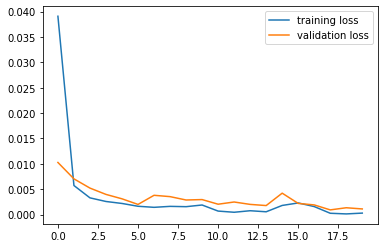

time: 255 ms (started: 2022-12-07 23:34:34 +00:00)


In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

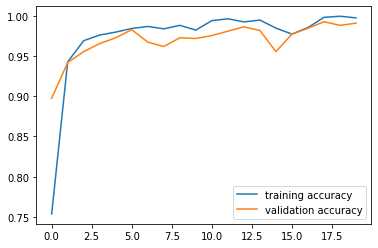

time: 166 ms (started: 2022-12-07 23:34:34 +00:00)


In [ ]:
for i in range(len(running_corrects_history)):
  running_corrects_history[i] = running_corrects_history[i].cpu()

for i in range(len(val_running_corrects_history)):
  val_running_corrects_history[i] = val_running_corrects_history[i].cpu()

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Sample of Dataset Classification

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

time: 922 ms (started: 2022-12-07 23:35:38 +00:00)


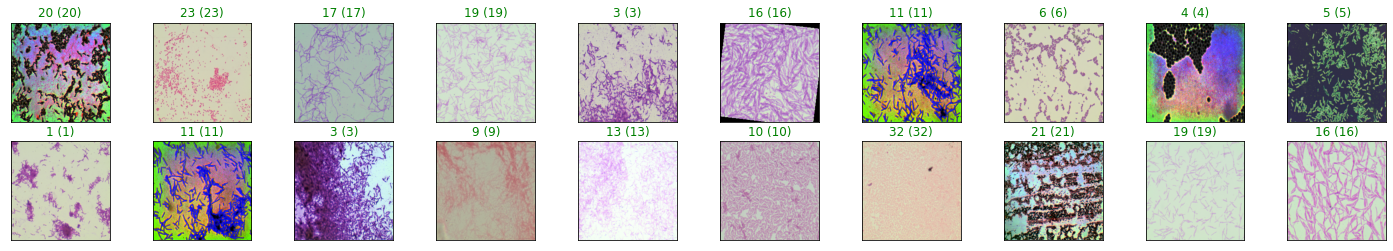

time: 2.09 s (started: 2022-12-07 23:35:40 +00:00)


In [ ]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert_to_image(images[idx].cpu()))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

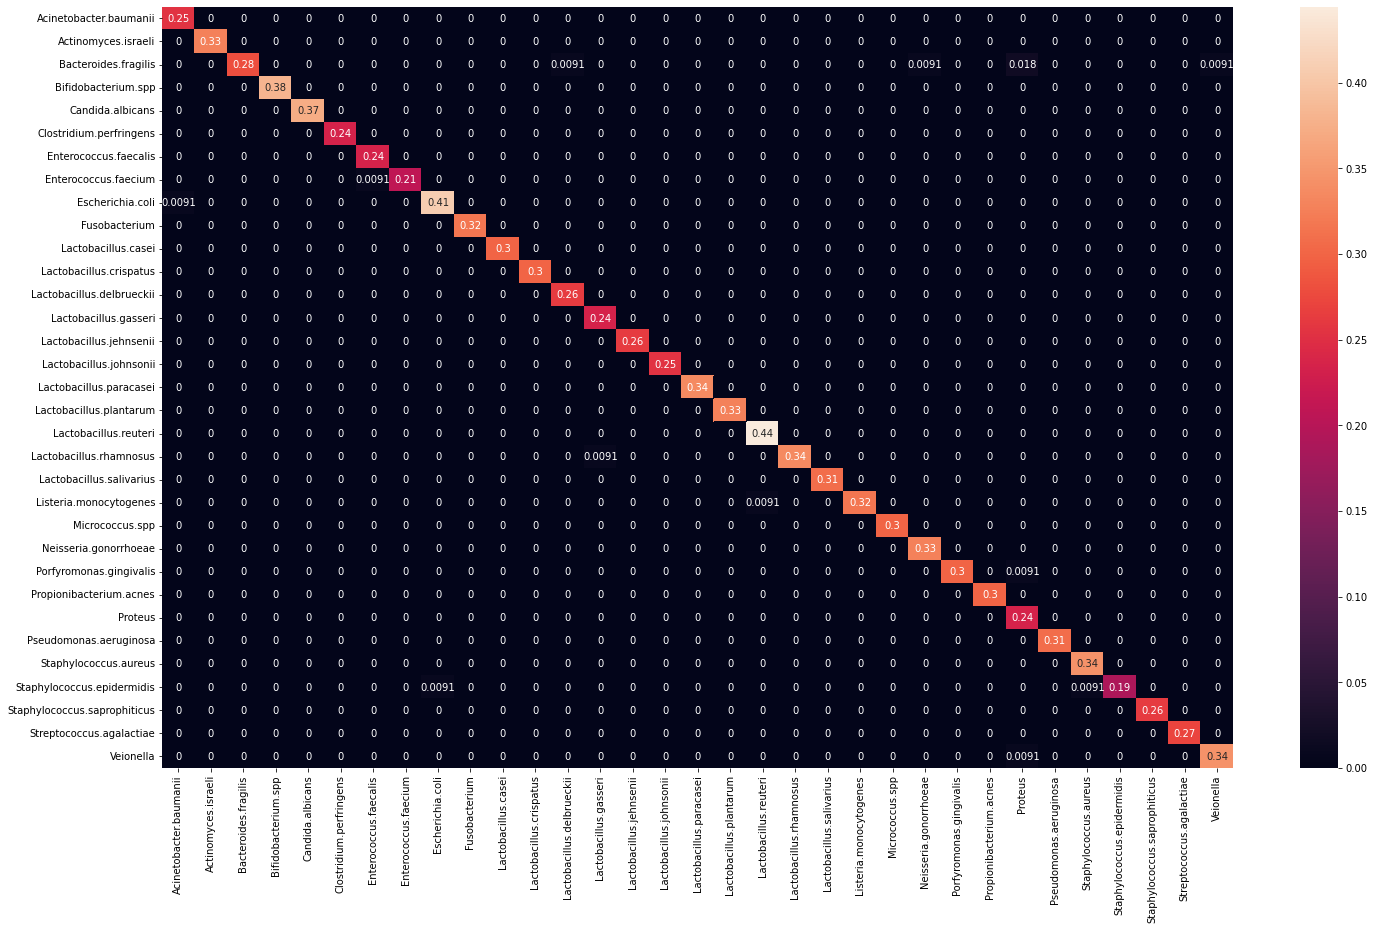

time: 41.7 s (started: 2022-12-07 23:35:45 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

test_running_corrects = 0.0

# iterate over test data
for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)

        test_loss = criterion(output, labels)
        test_score, test_preds = torch.max(output, 1)
        test_running_corrects += torch.sum(test_preds == labels.data)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24,14))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average = "weighted")

(0.9888920140997547, 0.9882139619220308, 0.9881537019817159, None)

time: 7.52 ms (started: 2022-12-07 23:36:27 +00:00)


In [1]:
test_epoch_acc = test_running_corrects.float()/len(test_loader.dataset)
print("test acc: {:.6f}".format(test_epoch_acc.item()))

test acc: 0.988726
time: 815 µs (started: 2022-12-07 23:36:27 +00:00)
